# Making Math "Rock"

Generative models are all the rage right now, and I've always been fascinated with them.

I've been playing and listening to music for most of my life, and the more music theory I learn, the more it becomes apparent how much structure there is in music.

For this project I'll attempt to generate songs in the math rock genre using, well, math. [Math rock](https://en.wikipedia.org/wiki/Math_rock) is one of my favorite genres of music - it's a modern progressive style of rock that often features elements such as [odd time signatures](https://en.wikipedia.org/wiki/Time_signature#Complex_time_signatures), [polyrhythm](https://en.wikipedia.org/wiki/Polyrhythm), [counterpoint](https://en.wikipedia.org/wiki/Counterpoint), unconventional song structures, and so on. [Melody 4 by Tera Melos](https://open.spotify.com/track/0JeVTUELKzEIsPtEWd1VDU?si=5f9d43510d4f4dce) is, in my opinion, a great example that characterizes many elements of the genre. It's not for everyone, and some say it just sounds like noise. This is beneficial because the results of the model are likely to be just noise, but the underlying structure of the songs used in the training data is going to be much more difficult to learn than a conventional rock song.

It's worth noting that I'll be using some of the code from the [TensorFlow tutorial on generating music with an RNN](https://www.tensorflow.org/tutorials/audio/music_generation). I think it does a good job with processing and preparing the data for the models (especially with using [windows](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) to create training sequences) and with using a custom loss function to encourage non-negative outputs from the model. This project is not just duplicating that tutorial as it also includes converting songs from audio to MIDI, generating songs with a variational autoencoder (VAE), and adding effects to the generated songs.

### Steps

1. Convert mp3 files to MIDI files with Spotify's [Basic Pitch](https://github.com/spotify/basic-pitch) library
2. Convert MIDI files to a NumPy array
3. Train two models:
    1. An long-short term memory (LSTM) network to predict the note(s) at the next time step
    2. A variational autoencoder (VAE) network to learn the latent space of the songs
4. Generate songs with the following methods
    1. **LSTM:** Passing a seed song snippet to the model and then continuously predict the note(s) at the next time step for a pre-determined amount of time
    2. **VAE:** Randomly sampling from the latent space and then decoding the sample to a song
5. Convert the generated song from a NumPy array to MIDI
6. Convert the MIDI file to an audio file
7. Add special effects with Spotify's [Pedalboard](https://github.com/spotify/pedalboard) library


### Shortcomings

Unfortunately my training data for this project isn't great. This requires mp3 files, and I mostly started listening to math rock after I got a Spotify subscription and stopped purchasing mp3s so I don't have a large library of songs to use.

The processing power for training the model is also limited. I'm training this on a desktop without a GPU, so we will train smaller networks with fewer training epochs.

## Converting mp3 files to MIDI

We'll do this with Spotify's [Basic Pitch](https://github.com/spotify/basic-pitch) library. This is what originally sparked the idea for this project because it made it feasible and easy to turn audio files into a numerical representation.

This library uses a model to predict the the notes being played - specifically the start/stop times, pitch, and the velocity (how hard a note is played). It's surprisingly fast and lightweight, and it only took a few minutes to convert the songs I wanted to use for my training data.

If you want to learn more, I recommend listening to the [Spotify Engineering Podcast (NerdOut)](https://open.spotify.com/show/5eXZwvvxt3K2dxha3BSaAe) episode on [Basic Pitch](https://open.spotify.com/episode/4wDDgWn037xjuq4Hr0u6a3?si=8a93b14952d546ca) and checking out the [announcement post](https://engineering.atspotify.com/2022/06/meet-basic-pitch/) and [website](https://basicpitch.spotify.com/) for it.

We'll start with some library imports and then grab the paths to the MP3 files we want to use for the training set before using basic pitch.

In [112]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from basic_pitch import inference as basic_pitch_inference
from basic_pitch import ICASSP_2022_MODEL_PATH  # Recommended when predicting for multiple songs

# Set up the directories
cwd = os.getcwd()
mp3_directory = os.path.join(cwd, "Data\\Songs\\")
midi_directory = os.path.join(cwd, "Data\\MIDIs\\")

# Rename all mp3s to numbers
mp3_index = 0
for root, dirs, files in os.walk(mp3_directory):
    for file in files:
        filepath = root + "\\" + file
        if filepath.lower().endswith(".mp3"):
            new_filepath = root + "\\" + str(mp3_index) + ".mp3"
            mp3_index += 1
            os.rename(filepath, new_filepath)

# Get a list of already converted MIDI files and the remaining mp3s that need to be converted
mp3s = []
midis = []
for root, dirs, files in os.walk(midi_directory):
    for file in files:
        filepath = root + "\\" + file
        if filepath.lower().endswith(".mid"):
            midis.append(filepath)
for root, dirs, files in os.walk(mp3_directory):
    for file in files:
        filepath = root + "\\" + file
        if filepath.lower().endswith(".mp3"):
            mp3s.append(filepath)

# Remove mp3s that have already been converted
mp3s = [mp3 for mp3 in mp3s if mp3.replace(".mp3", ".mid").replace("\\Songs\\", "\\MIDIs\\") not in midis]
print(f"Converting {len(mp3s)} mp3s to MIDI files...")

Converting 160 mp3s to MIDI files...


Next we'll use the basic pitch model to convert the mp3 files to MIDI files and save them in the MIDI directory. We'll also log any errors that occur into a separate file in case we run into issues and need to debug them.

It's important to note that the basic pitch model also outputs the notes, but we will not be using that here because we can extract them from the MIDI files and get additional information (e.g. the key and time signature) using other libraries like [music21](https://github.com/cuthbertLab/music21).

In [4]:
# Iterate through the mp3s, convert them to MIDI, and save them to the MIDI directory
basic_pitch_model = tf.saved_model.load(str(ICASSP_2022_MODEL_PATH))
log_file = open("Data\\Outputs\\processFailures.log", "w")  # To report issues
num_processed_songs = 0  # For reporting overall results
for i, mp3 in enumerate(mp3s):
    print(f"{i / len(mp3s):.0%}")
    mp3_to_convert = mp3s[i]

    # Use basic pitch model to convert mp3 to MIDI
    try:
        _, midi_data, _ = basic_pitch_inference.predict(mp3, basic_pitch_model)
        midi_path = mp3.replace("\\Songs\\", "\\MIDIs\\").replace(".mp3", ".mid")
        midi_data.write(midi_path)  # Save the MIDI file
        midis.append(midi_path)  # Add the MIDI file to the list of MIDI files
        num_processed_songs += 1

    # Logging errors that occur
    except Exception as e:
        print(f"Issue with {mp3}")
        log_file.write(f"{mp3}: {str(e)}\n")
        pass
log_file.close()

# Report the results
num_total_songs = len(mp3s)
print(
    f"Successfully processed {num_processed_songs}  \
      songs of {num_total_songs} ({(num_processed_songs / num_total_songs)})"
)

## Converting MIDI files to NumPy arrays

Here we'll take the MIDI files we created with basic pitch and convert them to NumPy arrays that we can use to train our model. The goal is to convert each song into an array with one columns for each time step, one row for each note, and a boolean (represented as a binary integer) if a given note was being played at a given timestamp.

Basic pitch extracts the velocity, but we're starting with a simple binary representation of the note being played to keep things simple due to hardware limitations. This will result in not needing as much memory (int8s take up significantly less space than floats) and the model will be able to train faster since it does not need to learn what the velocity of a note should be.

We'll start with ensuring that the ticks per beat is the same across all of the MIDI files. This is important because this defines how many "ticks" make up a note, and we need to be consistent across all of the songs.

In [6]:
import mido

# Double check that the ticks per beat are consistent in all of the MIDI files
# This will be used to specify the length in seconds to slice by
all_ticks_per_beat = []
for midi in midis:
    mid = mido.MidiFile(midi)
    all_ticks_per_beat.append(mid.ticks_per_beat)

assert len(set(all_ticks_per_beat)) == 1, "Different ticks per beat in MIDI files"
ticks_per_beat = all_ticks_per_beat[0]

Next, we'll do the actual parsing of the data from MIDI files into NumPy arrays. We have two options for how to represent this data:

1. Represent each note played as an event where each note is a row and there are columns for the pitch, time, and duration.
2. Represent the song as a [piano roll](https://en.wikipedia.org/wiki/Piano_roll) array where the X axis of the array is the time, the Y axis is the pitch, and the value is a boolean to indicate if a note was played at that time and pitch.

We are going to use option #1 because it is how the data is represented with the MIDI library we are using and because it is far more memory efficient. If we used option #2 for the songs being used for this project, then only 0.7% of the values in the parsed arrays would represent a note being played and 46 of the 127 possible pitches (36%!) have no notes being played at all!

Specifically, our data will look like this:

|Pitch | Start | End   | Step | Duration|
|------|-------|-------|------|---------|
|58    |2.03409|2.21818|0     |0.184091 |
|44    |2.35909|2.52045|0.325 |0.161634 |
|63    |2.37045|2.53182|0.0113|0.161364 |
|...   |...    |...    |...   |...      |
|43    |296.697|296.884|0.3136|0.186364 |
|38    |296.906|297.372|0.2091|0.465591 |
|48    |297.384|297.522|0.4772|0.138636 |

Here's a quick description of each of the columns in the data:

- **Pitch:** The pitch of the note being played (ranging from 0 to 127)
- **Start:** The number of seconds into the track when the note starts
- **End:** The number of seconds into the track when the note ends
- **Step:** The number of seconds when the note starts since the previous note started
- **Duration:** The duration of the note

In [7]:
import collections
import pretty_midi

def midi_to_notes(midi_file: str) -> pd.DataFrame:
    """
    Converts a MIDI file to a pandas DataFrame containing note information.

    Args:
        midi_file (str): The path to the MIDI file.

    Returns:
        pd.DataFrame: A DataFrame containing note information, including pitch, start time, end time, time since last note, and duration.
    """
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
      start = note.start
      end = note.end
      notes['pitch'].append(note.pitch)
      notes['start'].append(start)
      notes['end'].append(end)
      notes['step'].append(start - prev_start)  # Time since last note
      notes['duration'].append(end - start)  # Duration of note
      prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})


# Parse all of the MIDI files into one data frame of notes
all_notes = []
for f in midis:
    notes = midi_to_notes(f)
    all_notes.append(notes)

# Concatenate into one data frame and save to a CSV
all_notes = pd.concat(all_notes)
print('Number of notes parsed:', len(all_notes))
all_notes.to_csv('Data\\all_notes.csv')
all_notes

Number of notes parsed: 227997


,pitch,start,end,step,duration
0,58,2.034091,2.218182,0.000000,0.184091
1,44,2.359091,2.520455,0.325000,0.161364
2,63,2.370455,2.531818,0.011364,0.161364
3,45,2.788636,3.727273,0.418182,0.938636
4,71,2.811364,3.136364,0.022727,0.325000
...,...,...,...,...,...
1704,43,296.697727,296.884091,0.313636,0.186364
1705,38,296.906818,297.372727,0.209091,0.465909
1706,48,297.384091,297.522727,0.477273,0.138636
1707,45,297.697727,297.895455,0.313636,0.197727


Even though we aren't explicitly representing our data as a piano roll, we can easily visualize it as one. Here's an example of what that looks like for a random song:

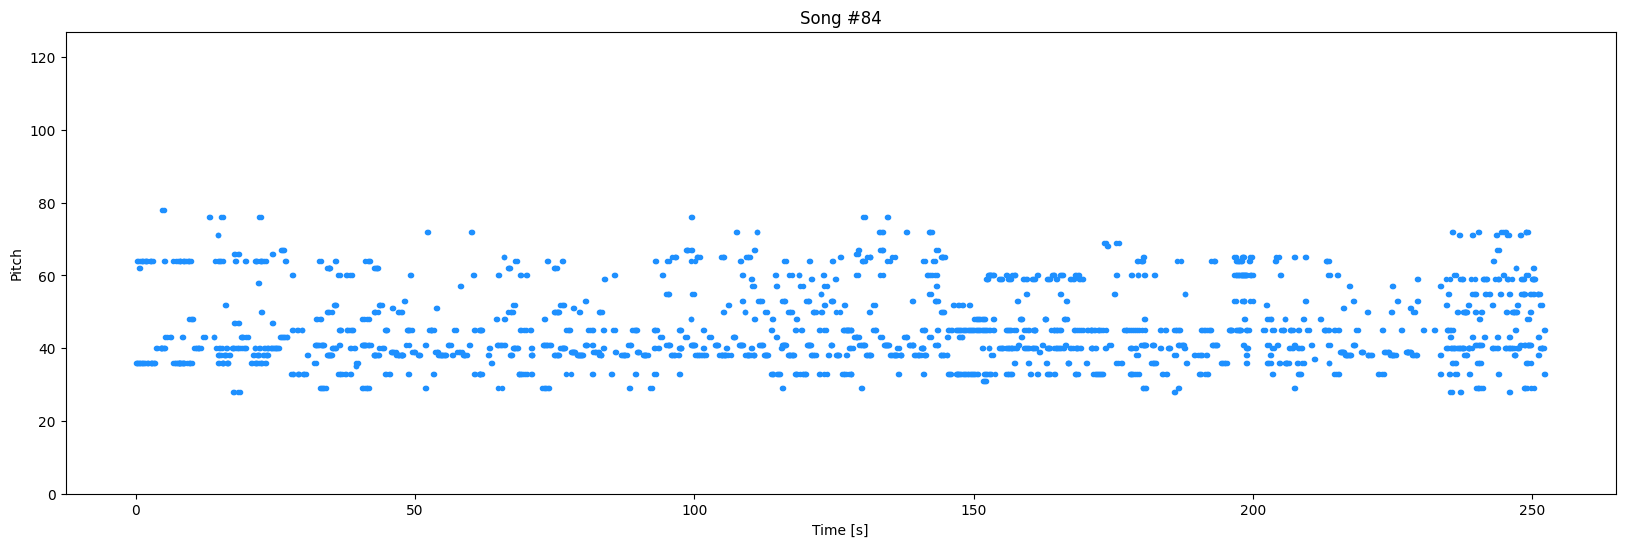

In [38]:
from typing import Optional
import matplotlib.pyplot as plt

def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None, title: Optional[str] = None):
    """
    Plots a piano roll visualization of the notes in a DataFrame.

    Args:
        notes (pd.DataFrame): A DataFrame containing note information, including pitch, start time, and end time.
        count (Optional[int]): The number of notes to plot. If None, all notes will be plotted.
        title (Optional[str]): The title of the plot.

    Returns:
        None
    """
    plt.figure(figsize=(20, 6))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
        plot_start_stop[:, :count], plot_pitch[:, :count], color="dodgerblue", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    plt.ylim(0, 127)
    plt.title(title)
    plt.show()


# Pick a random song to plot
sample_song = midis[np.random.randint(len(midis))]

# Grab the song name to use as the title
sample_song_name = sample_song.split("\\")[-1].replace(".mid", "")

# Parse the song into a DataFrame and plot it
sample_song = midi_to_notes(sample_song)
plot_piano_roll(sample_song, title=f'Song #{sample_song_name}')

I mentioned earlier that we chose not to represent the data as a piano roll because it would result in a very sparse array, and you can see how the higher and lower pitches contain no notes. It's also worth noting that the notes look fairly choppy. The [function](https://github.com/spotify/basic-pitch/blob/4855f26131c259a8795b2ae8124491ace83788c9/basic_pitch/inference.py#L262C1-L262C1) we're using from Spotify's [Basic Pitch](https://github.com/spotify/basic-pitch/tree/main) library to convert the audio files to MIDI files has [a few parameters](https://github.com/spotify/basic-pitch/blob/4855f26131c259a8795b2ae8124491ace83788c9/basic_pitch/inference.py#L280) we can try changing to see if we can reduce this choppiness and get a better representation of the data.

## Training the song generation model

TODO: Reword this to handle both models

Ultimately, we just want a classification model that predicts the probability of each note/pitch being played at each time step. We'll expand upon this more in the song generation section for how to continue generating songs beyond just the next timestamp.

There are a variety of models that can be used to generate music. Here we are going to try a few models in increasing levels of complexity. I'm doing this because it helps explain different concepts and components, and it gives options in case you are looking to borrow from this project.

Lastly, we're going to use Keras to build the models. Keras is a high-level API (built on top of TensorFlow) that makes it easy to build and train neural networks, and I think the simplicity and readability of the code is preferable for a blog post over more complex libraries like PyTorch or TensorFlow.

### Simple LSTM

This is the most basic model we'll build, and it had surprisingly good results! It's just a single layer [long short-term memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) network with 56 units that is fed to a dense layer that gives the probability of each note being played at the next timestamp.

LSTMs are a type of [recurrent neural network (RNN)](https://en.wikipedia.org/wiki/Recurrent_neural_network) that are designed to handle sequential data by "remembering" data from earlier in the sequence. I recommend reading Christopher Olah's [blog post on LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) if you want to learn more. I'm a big fan of his work, and I highly recommend the [Distill](https://distill.pub/) journal he cofounded to help explain research and concepts in a more interactive way than traditional papers. [Here is an example on memory within RNNs](https://distill.pub/2019/memorization-in-rnns/) that is germane to this project.

LSTMs are very useful for music generation because what is played at the next timestamp is most likely dependent on more than what was played at the previous timestamp. For example, if a song is in the key of C major, then there are only 7 possible notes that can be played if we ignore accidentals and octaves. If the model only pays attention to the previous note played, then it may not know if the song is in C major and will have a more difficult time distinguishing which notes could be played next. Another example is that songs  often have structure in the form of [chord progressions](https://en.wikipedia.org/wiki/Chord_progression), so if a model is trying to learn a song that is using the 12 bar blues chord progression (I-I-I-I-IV-IV-I-I-V-IV-I-V), then it will likely struggle if it only pays attention to the previous chord played.

TODO: Update to use the new data format

In [123]:
def get_num_ticks_for_seconds(seconds: float) -> int:
    """
    Converts seconds to ticks.

    Args:
        seconds (float): The number of seconds to convert.

    Returns:
        int: The number of ticks.
    """
    return int(seconds * ticks_per_beat)


# Determine how long of sequences to use for training and the seeds for the song generation
sequence_length = get_num_ticks_for_seconds(seconds=5)

# Take the list of arrays and convert it to semi-redundant sequences based on the max length of the sequence
step_ratio_from_example = 3 / 100  # TODO: Figure out what we should be using instead
step = int(step_ratio_from_example * sequence_length)

# Get the number of X axes to be able to create the array to fill
# Doing it this way to avoid having to create a list of all the sequences and then convert it to an array which is very memory heavy
num_sequences = 0
for song in midi_arrays:
    for i in range(0, len(song) - sequence_length, step):
        num_sequences += 1

# Initialize the arrays to fill
assert (
    len(set([song.shape[1] for song in midi_arrays])) == 1
), "All songs must have the same number of pitches"
num_pitches = midi_arrays[0].shape[1]
sequences = np.zeros((num_sequences, sequence_length, num_pitches), dtype=np.int8)
next_notes = np.zeros((num_sequences, num_pitches), dtype=np.int8)

# Iterate through the songs and filling the arrays
seq_num = 0
for song in midi_arrays:
    for i in range(0, len(song) - sequence_length, step):
        sequences[seq_num] = song[i : i + sequence_length]
        next_notes[seq_num] = song[i + sequence_length]
        seq_num += 1

# Save the arrays
output_file = os.path.join(cwd, "Data\\DataForModels\\LSTM\\training_data.npy")
np.save(output_file, sequences)
np.save(output_file.replace("_data.npy", "_labels.npy"), next_notes)

print("Number of sequences:", len(sequences))
print("Shape of sequences:", sequences[0].shape)

Number of sequences: 275358
Shape of sequences: (1100, 127)


In [127]:
# Input shape of the data for the model
sequence_length = sequences.shape[1]
num_pitches = sequences.shape[2]

# Simple LSTM
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.Input(shape=(sequence_length, num_pitches)))
lstm_model.add(tf.keras.layers.LSTM(56))
lstm_model.add(tf.keras.layers.Dense(num_pitches, activation="softmax"))
lstm_model.summary()

lstm_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Train the model w/ early stopping
epochs = 10  # Increase if the hardware can handle it
batch_size = 128
lstm_model.fit(
    sequences,
    next_notes,
    batch_size=batch_size,
    epochs=epochs
)

# Save the model
model_path = os.path.join(cwd, "Data\\Models\\simple_LSTM.h5")
lstm_model.save(model_path)

# Clear the training data from memory since it will no longer be needed
del sequences
del next_notes

### Variational autoencoder (VAE)

LSTMs can generate decent music, but research has shown other methods to be more effective. One of these methods is a [variational autoencoder (VAE)](https://en.wikipedia.org/wiki/Autoencoder#Variational_autoencoder_(VAE). This is a type of [autoencoder](https://en.wikipedia.org/wiki/Autoencoder) that is designed to learn a latent space that can be used to generate new data.

#### Autoencoders

Autoencoders are neat. They exemplify one of the largest strengths of neural networks - automatic feature engineering. They work by learning a compressed representation of the input data (referred to as the latent space, they can also be considered embeddings) through a neural network that tries to predict its input given a model architecture that initially restricts itself (referred to as the encoder) and then re-expands (referred to as the decoder). Here is a quick diagram of the typical model architecture for an autoencoder.

<img src="https://www.compthree.com/images/blog/ae/ae.png" width="500">
*Credit: [Steven Flores](https://www.compthree.com/blog/autoencoder/)*

After the model is trained, the encoder can transform data into the latent space, and the decoder can attempt to reconstruct the latent space back into the original form. This has a number of different use cases, but we're primarily interested in the generative capabilities of the decoder and a few fun things we can do with the latent space.

#### VAEs

Autoencoders don't restrict how the latent space is represented, and this results in a fixed latent space representation that often results in difficulty generating sensible reconstructions if provided data that is dissimilar to the data that it was trained on. 

To clarify, below is an example of reconstructing the interpolations between the latent space for different numbers from the MNIST handwritten data set with the decoder. For example, if the latent space for the number 0 is `[10, 2, 10]` and the latent space for the number 1 is `[20, 6, 2]` and we're interpolating in three steps, then the interpolated latent spaces would be `[12.5, 3, 8]`, `[15, 4, 6]`, and `[17.5, 5, 4]`. Note that all digits shown are the reconstructed from the latent space using the decoder.

<img src="https://github.com/MacalusoJeff/MacalusoJeff.github.io/blob/main/assets/images/autoencoderInterpolation.png?raw=true" width="700">

Notice how most of the interpolated digits don't look like an actual digit. Remember, this is because autoencoders learn a *fixed* latent space representation that.

Variational autoencoders (VAEs) are an extension of autoencoders that models the latent space as a probability distribution, and this allows the VAE to work better as a generative model. Specifically, the probability distribution will allow new data points to resemble the training data with additional variability introduced. The latent space in VAEs is also encouraged to have a continuous and smooth structure, so sampling from the latent space is more likely to produce realistic generations. TODO: Reword this, maybe include a link to a blog post

Here is an example of re-performing the interpolations on the latent space of the handwritten digits with a VAE:

<img src="https://github.com/MacalusoJeff/MacalusoJeff.github.io/blob/main/assets/images/vaeInterpolation.png?raw=true" width="700">

Notice how the reconstructions from the interpolations actually resemble digits now. The reconstructions of some of the digits (especially 3, 4, 5, and 9) are not as good as those from the previous autoencorder, and that shows how autoencoders and VAEs are suited to different tasks.

Interpolating the latent space has interesting possibilities for music. The first thing that came to mind for me is with genre blending. What would a mix between a math rock and a doom metal sound like? We could of course also try blending individual songs.

We can also generate realistic data by just sampling from the latent space and feeding that to the decoder. We'll get into the mechanics of generating songs in the next section, but this will allow us to not have to provide seeds to the model like we would have to in our LSTM.

#### Our VAE

This will be loosely based on the [MusicVAE](https://magenta.tensorflow.org/music-vae) model architecture created by Adam Roberts, Jesse Engel, Colin Raffel, Curtis Hawthorne, and Douglas Eck. I recommend reading their [paper](https://arxiv.org/abs/1803.05428) and checking out the [blog post on MusicVAE](https://magenta.tensorflow.org/music-vae). We won't directly copy the hierarchical part of their model architecture because I'm not concerned about generating longer samples, but we may play with the latent space from the encoder.

Our model will also be much smaller than MusicVAE's due to hardware limitations. MusicVAE's encoder (section 3.1 in their paper) is a two layer LSTM with 2048 units each fed into a fully connected layer with 512 units, and their decoder (section 3.2) is a bit more complex due to the hierarchical nature, but it involves multiple LSTMs with 1024 units each. My computer (that doesn't have a GPU) struggled to train a simple LSTM with 56 units, so we'll stick to a smaller model since I'll be training it on a virtual machine.


TODO: Update to use the new data format

In [130]:
# Parameters for the training data for the VAE model
num_samples = 50000
num_seconds = 10

# Randomply sample from song_array for training data for the VAE
sequence_length = get_num_ticks_for_seconds(seconds=num_seconds)
training_data = []
for i in range(num_samples):
    # Pick a random song
    random_song_num = np.random.randint(song_array.shape[0])
    song = song_array[random_song_num]

    # Pick a random snippet from the song
    random_start_time = np.random.randint(song.shape[0] - sequence_length)
    snippet = song[random_start_time : random_start_time + sequence_length]

    # Add the snippet to the training data
    training_data.append(snippet)

# Convert to a NumPy array
training_data = np.array(training_data)
print(training_data.shape)

(50000, 2200, 127)


In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device.type} device")

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim * 2)  # Two times the latent_dim for mean and log-variance
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Sigmoid activation to generate binary values
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        z_mean_logvar = self.encoder(x.view(x.size(0), -1))
        z_mean, z_logvar = z_mean_logvar[:, :latent_dim], z_mean_logvar[:, latent_dim:]
        z = self.reparameterize(z_mean, z_logvar)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_logvar

# Hyperparameters
num_pitches = training_data.shape[2]
latent_dim = 16  # Dimension of the latent space
batch_size = 256
learning_rate = 1e-3
epochs = 50

# Convert numpy array to PyTorch tensors and create a DataLoader
training_data = training_data.astype(np.float32)
train_dataset = TensorDataset(torch.from_numpy(training_data))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create VAE model and optimizer
vae_model = VAE(sequence_length * num_pitches, latent_dim)
vae_model.to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)

# Loss function - Binary cross entropy
criterion = nn.BCELoss(reduction='sum')

# Training loop
print("Beginning training...")
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        # Forward pass
        inputs = batch[0].to(device)
        reconstructions, z_mean, z_logvar = vae_model(inputs)

        # Compute reconstruction loss
        reconstruction_loss = criterion(reconstructions, inputs.view(inputs.size(0), -1))

        # Compute KL divergence
        kl_divergence = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())

        # Compute total loss
        loss = reconstruction_loss + kl_divergence

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print epoch loss
    average_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}")

# Saving the model
model_path = os.path.join(cwd, "Data\\Models\\vae.pt")
torch.save(vae_model.state_dict(), model_path)

# Clear the training data from memory since it will no longer be needed
del training_data

Using cpu device
Beginning training...
Epoch [1/50], Loss: 27906.6902
Epoch [2/50], Loss: 6023.7880
Epoch [3/50], Loss: 5806.2854
Epoch [4/50], Loss: 5691.2551
Epoch [5/50], Loss: 5607.6521
Epoch [6/50], Loss: 5539.2009
Epoch [7/50], Loss: 5483.6997
Epoch [8/50], Loss: 5435.7185
Epoch [9/50], Loss: 5394.3310
Epoch [10/50], Loss: 5357.2222
Epoch [11/50], Loss: 5323.0161
Epoch [12/50], Loss: 5292.0599
Epoch [13/50], Loss: 5265.8475
Epoch [14/50], Loss: 5237.8747
Epoch [15/50], Loss: 5214.2010
Epoch [16/50], Loss: 5193.9044
Epoch [17/50], Loss: 5169.9955
Epoch [18/50], Loss: 5148.3249
Epoch [19/50], Loss: 5130.7909
Epoch [20/50], Loss: 5114.4721
Epoch [21/50], Loss: 5096.0215
Epoch [22/50], Loss: 5075.4627
Epoch [23/50], Loss: 5063.0211
Epoch [24/50], Loss: 5045.6652
Epoch [25/50], Loss: 5031.9382
Epoch [26/50], Loss: 5016.6016
Epoch [27/50], Loss: 4998.0024
Epoch [28/50], Loss: 4986.7931
Epoch [29/50], Loss: 4969.9283
Epoch [30/50], Loss: 4956.7215
Epoch [31/50], Loss: 4945.3637
Epoch [3

## Generating songs

The two different models we trained have two quite different methods for generating new songs.

### Generating songs with the LSTM

The song generation will be pretty straightforward. We will have to feed the model a "seed" of a sequence of notes to predict the next timestamp. We'll then iterate over this to continuously generate the next timestamp given the previous predictions. For example, if our model generates the 6th timestamp given the previous 5 timestamps, then it will generate the 7th timestamp given the timestamps 2-6, and so on. In this example, our model will no longer be using the seed after the fifth prediction. We will repeat this process enough times until we have an adequate length song.

Because our model outputs the probability of a note being played, we can randomly sample the predictions to get the notes played at that timestsamp. This would be more difficult if we wanted to capture the velocity of a note, but we're just using a binary representation of whether a note is played or not.

We'll begin with gathering our seeds. This will just be the beginning of different songs that were used in the training set.


TODO: Update to use the new data format

In [ ]:
# TODO: Code here to get the seeds

In [ ]:
def generate_song_lstm(seed: np.ndarray, model, ticks_per_beat: int, num_seconds=15) -> np.ndarray:
    """
    Generates a song based on a seed array and a trained model

    Args:
        seed (np.ndarray): The seed array to use to generate the song
        model (keras.Model): The trained model to use to generate the song
        ticks_per_beat (int): The number of ticks per beat in the MIDI files
        num_seconds (int, optional): The number of seconds to generate. Defaults to 15.

    Returns:
        np.ndarray: The generated song
    """
    song = seed
    seq_length = seed.shape[0]
    num_notes = num_seconds * ticks_per_beat
    for i in range(num_notes):
        probabilities = model.predict(song[-seq_length:].reshape(1, seq_length, 127))
        notes_played = np.random.binomial(n=1, p=probabilities)
        song = np.append(song, notes_played, axis=0)
    return song


generated_song = generate_song_lstm(seed=seed, model=lstm_model, ticks_per_beat=ticks_per_beat, num_seconds=20)

### Generating songs with the VAE

TODO: Explain

In [186]:
# Generating songs w/ the VAE

# Generate samples using the trained VAE
def generate_song_vae(model) -> np.ndarray:
    """
    Generates a song using the trained VAE

    Returns:
        np.ndarray: The generated song
    """
    z = torch.randn(1, latent_dim).to(device)
    generated_song = model.decoder(z)
    generated_song = generated_song.view(sequence_length, num_pitches)
    generated_song = generated_song.round().detach().numpy().astype(np.int8)
    return generated_song


generated_song = generate_song_vae(vae_model)
generated_song

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

## Saving the generated songs as MIDI

The generated song is currently just a numpy array, so we'll need to do some work to convert it back to a MIDI file. We'll start by converting from the piano roll array into an array with the start/end time of each note played.

So our current generated song is an array that looks like this:

|Pitch   | Timestamp 0 | Timestamp 1 | ... | Timestamp *n* |
|--------|-------------|-------------|-----|---------------|
| **1**  | 0           | 0           | ... | 0             |
| **2**  | 1           | 1           | ... | 0             |
| **3**  | 0           | 0           | ... | 1             |
| ...    | ...         | ...         | ... | ...           |
| **127**| 0           | 0           | ... | 0             |

And we will convert it to an array that looks like this for all notes that were played:

|Pitch     | Start Time | End Time |
|----------|------------|----------|
| 60       | 0          | 0.5      |
| 62       | 2.5        | 4.5      |
| 122      | 2.5        | 4.5      |

TODO: Update to use the new data format

In [188]:
def reshape_array_for_note_start_end(
    arr: np.ndarray, ticks_per_beat: int = 220
) -> np.ndarray:
    """
    Find the start and end of consecutive True values in a 2D array.
    Thanks ChatGPT!

    Args:
        arr (np.ndarray): The array to reshape
        ticks_per_beat (int, optional): The number of ticks per beat in the MIDI files. Defaults to 220.

    Returns:
        np.ndarray: The reshaped array
    """
    if arr.shape[1] == 127:
        arr = arr.T

    sequences = []
    for row_idx in range(arr.shape[0]):
        row = arr[row_idx]
        start, end = None, None
        for col_idx in range(arr.shape[1]):
            if row[col_idx]:
                if start is None:
                    start = col_idx
                end = col_idx
            elif start is not None:
                sequences.append((row_idx, start, end))
                start, end = None, None
        if start is not None:
            sequences.append((row_idx, start, end))
    output_array = np.array(sequences, dtype=float)

    # Convert to seconds
    output_array[:, 1] /= ticks_per_beat
    output_array[:, 2] /= ticks_per_beat

    # Order the array by start time
    output_array = output_array[output_array[:, 1].argsort()]
    return output_array  # (pitch, start, end)


song_snippet_start_ends = reshape_array_for_note_start_end(generated_song)
song_snippet_start_ends[:10]

array([[68.        ,  0.11363636,  0.11363636],
       [72.        ,  0.11818182,  0.11818182],
       [68.        ,  0.14090909,  0.15      ],
       [37.        ,  0.55454545,  0.55454545],
       [37.        ,  0.56363636,  0.59090909],
       [37.        ,  0.61363636,  0.61363636],
       [37.        ,  0.62272727,  0.62272727],
       [37.        ,  0.82727273,  0.90909091],
       [61.        ,  0.86818182,  0.87272727],
       [37.        ,  0.91818182,  0.94090909]])

We need to do a little more data processing before being able to create a MIDI from our generated song. This is because the time argument for adding notes to a MIDI file with Mido is the time since the last note was played, not the absolute time. So if we have a song that has a note played at 0.5 seconds and another note played at 1.5 seconds, then the time argument for the second note will be 1 second.

We'll have to calculate the difference between the start time of each note and the end time of the previous note to get the time argument for each note. Fortunately, this is really easy to do with pandas. We'll start by converting our array of notes into a pandas DataFrame. Next, we'll use the `melt` method to convert the DataFrame from wide to long format where the start and end of each note has its own row. We'll then sort the DataFrame by the timestamp and lag the time of the next note with the `shift` method. Finally, we'll calculate the difference between the start time of each note and the end time of the previous note.

Our array of notes will now become a data frame that looks like this:

|Pitch     | Type | Time | lagged_time | time_delta|
|----------|------|------|-------------|-----------|
| 60       | start| 0    | np.NaN      | 0         |
| 60       | end  | 0.5  | 0           | 0.5       |
| 62       | start| 2.5  | 0.5         | 2.0       |
| 122      | start| 2.5  | 2.5         | 0         |
| 62       | end  | 4.5  | 2.5         | 2.0       |
| 122      | end  | 4.5  | 4.5         | 0         |

And we can now use the `time_delta` column to add the notes to the MIDI file.


TODO: Update to use the new data format

In [190]:
def get_note_time_deltas(note_start_end_array: np.ndarray) -> pd.DataFrame:
    """
    Further formats the array to get time delta between each note to prep the data for MIDI conversion

    Args:
        note_start_end_array (np.ndarray): The array to reshape from reshape_array_for_note_start_end()

    Returns:
        pd.DataFrame: The reshaped array
    """
    # Formatting further to convert to MIDI
    # This is because we need the time delta between each note and if that note was a start or end
    # Using Pandas to do the remainder of the processing due to ease of use
    midi_df = pd.DataFrame(note_start_end_array, columns=["pitch", "start", "end"])
    midi_df = midi_df.melt(id_vars="pitch").rename(
        columns={"variable": "type", "value": "time"}
    )
    midi_df = midi_df.sort_values(by="time").reset_index(drop=True)
    midi_df["lagged_time"] = midi_df["time"].shift(-1)
    midi_df["time_delta"] = (midi_df["lagged_time"] - midi_df["time"]).fillna(0)
    return midi_df


song_snippet_for_output = get_note_time_deltas(song_snippet_start_ends)
song_snippet_for_output[:10]

,pitch,type,time,lagged_time,time_delta
0,68.0,start,0.113636,0.113636,0.000000
1,68.0,end,0.113636,0.118182,0.004545
2,72.0,start,0.118182,0.118182,0.000000
3,72.0,end,0.118182,0.140909,0.022727
4,68.0,start,0.140909,0.150000,0.009091
5,68.0,end,0.150000,0.554545,0.404545
6,37.0,end,0.554545,0.554545,0.000000
7,37.0,start,0.554545,0.563636,0.009091
8,37.0,start,0.563636,0.590909,0.027273
9,37.0,end,0.590909,0.613636,0.022727


In [194]:
def create_midi(
    df: pd.DataFrame, midi_path: str, ticks_per_beat: int = 220, tempo: int = 500000
) -> None:
    """
    Creates a MIDI file from a dataframe of notes from get_note_time_deltas()

    Args:
        df (pd.DataFrame): The dataframe of notes from get_note_time_deltas()
        midi_path (str): The path to save the MIDI file to
        ticks_per_beat (int, optional): The number of ticks per beat in the MIDI files. Defaults to 220.
        tempo (int, optional): The tempo of the MIDI file. Defaults to 500000.

    Returns:
        None: Saves the MIDI file to the specified path
    """
    mid = mido.MidiFile()
    track = mido.MidiTrack()
    mid.tracks.append(track)
    track.append(mido.MetaMessage("set_tempo", tempo=tempo, time=0))
    mid.ticks_per_beat = ticks_per_beat
    for row in df.itertuples():
        if row.type == "start":
            track.append(
                mido.Message(
                    "note_on",
                    note=int(row.pitch),
                    velocity=64,
                    time=int((row.time_delta * ticks_per_beat * 2)),
                )
            )
        else:
            track.append(
                mido.Message(
                    "note_on",
                    note=int(row.pitch),
                    velocity=0,
                    time=int((row.time_delta * ticks_per_beat) * 2),
                )
            )
    mid.save(midi_path)
    print(f"MIDI file saved to {midi_path}")


midi_output_path = os.path.join(cwd, "Data\\Outputs\\GeneratedSongMIDIs\\VAE\\")
create_midi(song_snippet_for_output, midi_output_path)  # TODO: Update this

MIDI file saved to c:\Users\jemacalu\OneDrive - Microsoft\Projects\Misc\Learning\Making-Math-Rock\Data\Outputs\GeneratedSongMIDIs\VAE\0.mid


In [222]:
# Using the above functions to generate multiple songs from the VAE
num_songs_to_generate = 30
for i in range(num_songs_to_generate):
    generated_song = generate_song_vae(vae_model)
    song_snippet_start_ends = reshape_array_for_note_start_end(generated_song)
    song_snippet_for_output = get_note_time_deltas(song_snippet_start_ends)
    midi_output_path = os.path.join(cwd, f"Data\\Outputs\\GeneratedSongMIDIs\\VAE\\{i}.mid")
    create_midi(song_snippet_for_output, midi_output_path)

## Converting to audio

How has nobody named software dealing with audio files "audiofile"?

TODO: Talk about soundfonts

In [221]:
from midi2audio import FluidSynth

generated_midi_directory = os.path.join(cwd, "Data\\Outputs\\GeneratedSongMIDIs")

# Grabbing the soundfont files for the MIDI
piano_soundfont_path = os.path.join(
    cwd,
    "Data\\Soundfonts\\GeneralUser GS 1.442 MuseScore\\GeneralUser GS MuseScore v1.442.sf2",
)
guitar_soundfont_path = os.path.join(
    cwd,
    "Data\\Soundfonts\\Electric Guitar Jazz\\EGuitarFSBS-bridge-jazz-small-20220911.sf2",
)

# Getting a list of the MIDI files to convert
generated_midis = []
for root, dirs, files in os.walk(generated_midi_directory):
    for file in files:
        filepath = root + "\\" + file
        if filepath.lower().endswith(".mid"):
            generated_midis.append(filepath)

# Converting the MIDI files to WAV files
for midi in generated_midis:
    # Saving the generated song as a WAV
    # Doing this twice - once as a piano and once as a guitar
    # midi = midi.replace('GeneratedSongMIDIs', 'GeneratedSongWAVs')
    output_wav_piano = midi.replace(".mid", "_piano.wav").replace("GeneratedSongMIDIs", "GeneratedSongWAVs")
    output_wav_guitar = output_wav_piano.replace("piano", "guitar").replace("GeneratedSongMIDIs", "GeneratedSongWAVs")
    FluidSynth(sound_font=piano_soundfont_path).midi_to_audio(midi, output_wav_piano)
    FluidSynth(sound_font=guitar_soundfont_path).midi_to_audio(midi, output_wav_guitar)

In [223]:
FluidSynth(sound_font=piano_soundfont_path).play_midi(midi)

VAE: 3, 6, 8, 10, 18, 27

## Adding effects

TODO: Talk about pedalboard, upload a pic of my pedalboard, make some cool sounding stuff

# Wrapping up

I hope you enjoyed reading about this project! I had a lot of fun working on it, and hopefully it was interesting to you as well. I may revisit this in the future when I have access to better hardware, and I listed a few ideas of how to continue expanding this below.

Feel free to reach out to me via email or on [LinkedIn](https://www.linkedin.com/in/macalusojeff/) with any questions, and all of the code for this is listed in [the GitHub repository](https://github.com/MacalusoJeff/Making-Math-Rock).

## How to improve this project

- Add more training data
- Represent the data more efficiently
- Use more complex models, train them for more epochs

## How to expand this project

- Genre blending
- Play around with the latent space of the VAE